In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Zvolení druhu konečného prvku, nainicializování bodů a vah Gaussovy-Legendreovy kvadratury

In [2]:
n = 3 # 1D intervaly (LINE3) (2 vrcholy + 1 midpoint)

line_o3_QP = np.array([-np.sqrt(3/5), 0, np.sqrt(3/5)], dtype=np.float64) # Gaussovy body
line_o3_QW = np.array([5/9, 8/9, 5/9], dtype=np.float64) # vahy

nqp = line_o3_QP.shape[0] # celkovy pocet pouzitych Gaussovych bodu

### Definice kvadratických a lineárních násadových funkcí a jejich derivací na příslušném referenčním prvku

Lineární násadové funkce jsou použity pro zobrazení bodů referenčního prvku na body konkrétního konečného prvku.

In [3]:
def line3_N(r: np.ndarray) -> np.ndarray:
    
    return np.vstack((-0.5*(1-r)*r, (1-r)*(1+r), 0.5*(1+r)*r))

def line3_dNdxi(r: np.ndarray) -> np.ndarray:
    
    return np.vstack((-0.5+r, -2*r, 0.5+r))

def line_M(r: np.ndarray) -> np.ndarray:
    
    return np.vstack((0.5*(1-r), 0.5*(1+r)))

def line_dMdxi(r: np.ndarray) -> np.ndarray:
    
    return np.vstack((-0.5+0*r, 0.5+0*r))

### Definice funkce na pravé straně

In [4]:
def load_func(x: np.ndarray) -> np.ndarray:

    return np.sin(x)

### Výpočet hodnot násadových funkcí a hodnot jejich derivací v bodech Gaussovy-Legendreovy kvadratury

In [5]:
line_o3_QP_N = line3_N(line_o3_QP)

line_o3_QP_M = line_M(line_o3_QP)

dNdxi = line3_dNdxi(line_o3_QP)

dMdxi = line_dMdxi(line_o3_QP)

### Dekompozice výpočetní oblasti na konečné prvky

In [6]:
N = 4
ne = N - 1 # pocet pouzitych konecnych prvku
nn = N + N - 1 # pocet uzlovych bodu (a nasadovych funkci)

ind = np.array([ i for i in range(nn) ], dtype=np.int64) # pole globalnich indexu
mesh_ele = np.column_stack((ind[0:-2:2], ind[1:-1:2], ind[2::2])) # matice urcujici vztah mezi lokalnimi (na jednom konecnem prvku)
                                                                  # a globalnimi indexy uzlovych bodu (a nasadovych funkci) (zobrazeni l2g)
xx = np.linspace(0, np.pi, nn)
mesh_coo = xx # uzlove body

### Sestavení matice tuhosti a vektoru zatížení

In [7]:
K = np.zeros(shape=(nn, nn), dtype=np.float64)

f = np.zeros(shape=nn, dtype=np.float64)

for e in range(ne):
    ele_e = mesh_ele[e, :]

    p = mesh_coo[ele_e][::2]
    P = np.zeros(shape=(2, nqp), dtype=np.float64)
    P.T[:, :] = p

    j = np.sum(P.T*dMdxi.T, axis=1) # hodnoty jakobianu zobrazeni Z^e v Gaussovych bodech

    detj = j # hodnoty determinantu jakobianu zobrazeni Z^e v Gaussovych bodech
    absdetj = np.abs(detj)

    invj = 1/j # hodnoty inverze jakobianu zobrazeni Z^e v Gaussovych bodech

    dNdX = dNdxi*invj

    tmp = (dNdX*absdetj*line_o3_QW) @ dNdX.T # lokalni matice tuhosti
    Kloc_flattened = tmp.flatten()

    tmp = np.ones(shape=n, dtype=np.int64)
    K_ind_i = np.kron(ele_e, tmp)
    K_ind_j = np.kron(tmp, ele_e)
    K[K_ind_i, K_ind_j] += Kloc_flattened

    line_o3_QP_e = p @ line_o3_QP_M # zobrazeni Gaussovych bodu na konecny prvek
    line_o3_QP_load_func = load_func(line_o3_QP_e)
    floc = (line_o3_QP_load_func*absdetj*line_o3_QW) @ line_o3_QP_N.T # lokalni vektor zatizeni

    f[ele_e] += floc

print(np.linalg.norm(K @ np.ones(shape=nn))) # test

9.485749680535094e-16


### Zahrnutí Dirichletovy okrajové podmínky, sestavení a vyřešení příslušné soustavy

In [8]:
nnd = 2 # pocet nasadovych funkci majicich nenulovou stopu na Gamma_D
ind_d = np.array([ind[0], ind[-1]], dtype=np.int64) # globalni indexy nasadovych funkci majicich nenulovou stopu na Gamma_D

g = np.array([1.2, 1.7], dtype=np.float64)

B = np.zeros(shape=(nnd, nn), dtype=np.float64)
B[[ i for i in range(nnd) ], ind_d] = 1

A = np.zeros(shape=(nn + nnd, nn + nnd), dtype=np.float64)
A[0:nn, 0:nn] = K
A[nn:, 0:nn] = B
A[0:nn, nn:] = B.T

b = np.zeros(shape=(nn + nnd), dtype=np.float64)
b[0:nn] = f
b[nn:] = g

fem_sol_c = np.linalg.solve(A, b)[0:nn]

### Vykreslení přibližného řešení, porovnání s přesným řešením

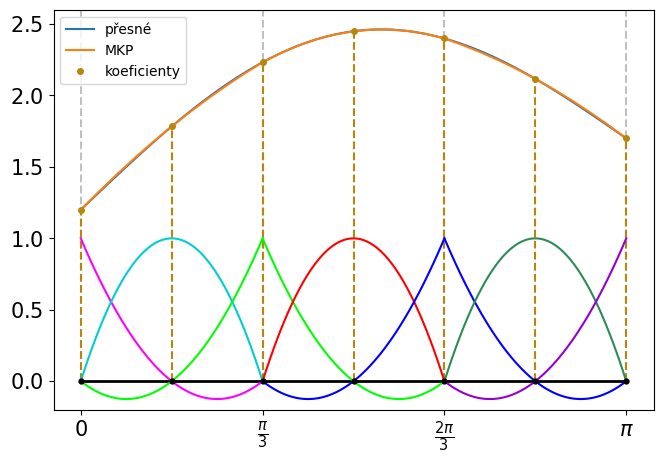

In [9]:
n_ele = ne
n_ele_midp = 1
n_nod = nn
plot_mesh_midp_span = 4
n_plot_mesh_ele_midp_spans = n_ele_midp + 1
n_plot_mesh_midp_spans = n_nod - 1
plot_mesh_ele_span = n_plot_mesh_ele_midp_spans*plot_mesh_midp_span + n_ele_midp
plot_mesh_refele_p = np.linspace(-1, 1, plot_mesh_ele_span + 2)
n_plot_mesh_p = n_plot_mesh_midp_spans*plot_mesh_midp_span + n_nod
plot_mesh_fem_sol = np.linspace(0, np.pi, n_plot_mesh_p)
plot_mesh_fem_sol_v = np.zeros(shape=n_plot_mesh_p, dtype=np.float64)
plot_mesh_fem_sol_v[::plot_mesh_midp_span + 1] = fem_sol_c

tmp = np.zeros(shape=n_plot_mesh_ele_midp_spans*plot_mesh_midp_span, dtype=np.float64)
for i in range(n_plot_mesh_ele_midp_spans):
    midp_span_sl_offset = i
    midp_span_sl_start = i*plot_mesh_midp_span
    midp_span_sl_end = (i + 1)*plot_mesh_midp_span
    tmp[midp_span_sl_start:midp_span_sl_end] = plot_mesh_refele_p[midp_span_sl_start + midp_span_sl_offset + 1:
                                                                  midp_span_sl_end + midp_span_sl_offset + 1]
tmp = line3_N(tmp)

plot_mesh_ele_nodp_idx = np.zeros(shape=n, dtype=np.int64)
for i in range(n_ele):
    ele_idx_offset = i
    ele_start_idx = i*(plot_mesh_ele_span + 2) - ele_idx_offset
    ele_end_idx = (i + 1)*(plot_mesh_ele_span + 2) - ele_idx_offset - 1

    plot_mesh_ele_nodp_idx[0] = ele_start_idx
    for j in range(1, n - 1):
        plot_mesh_ele_nodp_idx[j] = ele_start_idx + j*(plot_mesh_midp_span + 2) - 1
    plot_mesh_ele_nodp_idx[2] = ele_end_idx

    plot_mesh_ele_midp_span_v = np.sum((tmp.T*plot_mesh_fem_sol_v[plot_mesh_ele_nodp_idx]).T, axis=0)

    for j in range(n_plot_mesh_ele_midp_spans):
        midp_span_sl_offset = j
        midp_span_sl_start = j*plot_mesh_midp_span
        midp_span_sl_end = (j + 1)*plot_mesh_midp_span
        plot_mesh_fem_sol_v[ele_start_idx + midp_span_sl_start + midp_span_sl_offset + 1:
                            ele_start_idx + midp_span_sl_end + midp_span_sl_offset + 1] = plot_mesh_ele_midp_span_v[midp_span_sl_start:midp_span_sl_end]

plot_mesh_tru_sol = np.linspace(0, np.pi, 50)
plot_mesh_tru_sol_v = np.sin(plot_mesh_tru_sol) + (0.5/np.pi)*plot_mesh_tru_sol + 1.2

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0, 0, 1, 1])
ymin, ymax = -0.2, 2.6
ax.set_ylim(ymin=ymin, ymax=ymax)
ax.plot(plot_mesh_tru_sol, plot_mesh_tru_sol_v, label="přesné")

ax.plot([0, np.pi], [0, 0], color="black", lw=2)
for i in range(0, n_nod, 2):
    ax.plot([mesh_coo[i], mesh_coo[i]], [0, ymax], linestyle="--", color="silver")

for i in range(n_nod):
    ax.plot([mesh_coo[i], mesh_coo[i]], [0, fem_sol_c[i]], linestyle="--", color="darkgoldenrod")

plot_mesh_refele_p = np.linspace(-1, 1, 50)
plot_mesh_refele_basv = line3_N(plot_mesh_refele_p)
colors_bas = ["magenta", "darkturquoise", "lime", "red", "blue", "seagreen", "darkviolet"]
for i in range(n_ele):
    ele_idx_offset = i
    ele_start_idx = i + ele_idx_offset
    ele_end_idx = i + ele_idx_offset + 2
    plot_mesh_ele_p = np.linspace(mesh_coo[ele_start_idx], mesh_coo[ele_end_idx], 50)

    ax.plot(plot_mesh_ele_p, plot_mesh_refele_basv[0, :], color=colors_bas[mesh_ele[i, 0]])
    ax.plot(plot_mesh_ele_p, plot_mesh_refele_basv[1, :], color=colors_bas[mesh_ele[i, 1]])
    ax.plot(plot_mesh_ele_p, plot_mesh_refele_basv[2, :], color=colors_bas[mesh_ele[i, 2]])

ax.plot(mesh_coo, np.zeros(shape=n_nod), 'k.', markersize=7)

ax.plot(plot_mesh_fem_sol, plot_mesh_fem_sol_v, label="MKP")
ax.plot(mesh_coo, fem_sol_c, linestyle="None", marker="o", markersize=4, color="darkgoldenrod", label="koeficienty")
ax.legend()

ax.set_xticks([0, (1/3)*np.pi, (2/3)*np.pi, np.pi])
ax.set_xticklabels([r'$0$', r'$\frac{\pi}{3}$', r'$\frac{2\pi}{3}$', r'$\pi$'], fontsize=15)
ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2, 2.5])
ax.set_yticklabels([r'$0.0$', r'$0.5$', r'$1.0$', r'$1.5$', r'$2.0$', r'$2.5$'], fontsize=15)

plt.show()